In [208]:
import numpy as np
import matplotlib.pyplot as plt

import itertools
import time
import os

import glob

#from natsort import natsorted
from IPython.display import clear_output, display

from tqdm.auto import tqdm

from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

from shapely.geometry import Polygon
from shapely.ops import unary_union

import geopandas as gpd

In [209]:
fblocks = np.array([
    [(0,0,0),(1,0,1),(2,0,0),(3,0,1),(4,0,0)],
    [(0,0,0),(1,0,1),(2,0,0),(2,-1,1),(1,1,0)],
    [(0,0,0),(1,0,1),(2,0,0),(0,1,1),(2,-1,1)],
    [(0,0,0),(1,0,1),(2,0,0),(-1,0,1),(0,-1,1)],
    [(0,0,0),(-1,0,1),(1,0,1),(0,1,1),(0,-1,1)],
    [(0,0,1),(1,0,0),(2,0,1),(0,1,0),(0,-1,0)],
    [(0,0,0),(1,0,1),(2,0,0),(3,0,1),(0,1,1)],
    [(0,0,0),(0,1,1),(2,0,0),(2,1,1),(1,1,0)],
    [(0,0,1),(1,0,0),(2,0,1),(0,1,0),(0,2,1)],
    [(0,0,1),(-1,0,0),(0,1,0),(1,1,1),(2,1,0)],
    [(0,0,0),(1,0,1),(0,1,1),(1,1,0),(-1,1,0)],
    [(0,0,0),(1,0,1),(0,1,1),(1,1,0)],
    [(0,0,0),(1,1,0),(2,2,0),(0,1,1),(1,2,1)]
])


board_size = 8

# fblocks = np.array([
#    [(0,0,0)],
#    [(0,0,0),(-1,0,1),(0,-1,1)],
#    [(0,0,0),(0,1,1),(0,2,0),(0,3,1)],
#    [(0,0,0),(-1,0,1),(0,-1,1),(0,-2,0)],
#    [(0,0,1),(-1,0,0),(0,-1,0),(0,-2,1)],
#    [(0,0,0),(0,1,1),(0,2,0),(0,3,1)],
#    [(0,0,0),(0,1,1),(0,2,0)],
#    [(0,0,1),(0,1,0)]
# ])

# board_size = 5

blocks = []
for block in fblocks:
    blocks.append(np.array(block))
fblocks = np.array(blocks).copy()

dcol = np.random.rand(len(fblocks),3)

In [210]:
def rotation(block, rot=0):
    block = block.copy()
    rblock = block[...,:-1]
    if rot==0:
        rblock = np.array(list(map(lambda x : [x[0],x[1]], rblock)))
    elif rot==1:
        rblock = np.array(list(map(lambda x : [x[1],-x[0]], rblock)))
    elif rot==2:
        rblock = np.array(list(map(lambda x : [-x[0],-x[1]], rblock)))
    else:
        rblock = np.array(list(map(lambda x : [-x[1],x[0]], rblock)))
    block[...,:-1] = rblock
    return block

def translation(block, vector):
    block = block.copy()
    rblock = block[...,:-1]
    rblock = np.array(list(map(lambda x : x + vector, rblock)))
    block[...,:-1] = rblock
    return block

def mirroring(block, mirror):
    block = block.copy()
    rblock = block[...,:-1]
    if mirror:
        rblock = np.array(list(map(lambda x : [-x[0],x[1]], rblock)))
    block[...,:-1] = rblock
    return block

In [211]:
def move_block(block, setting):
    block = mirroring(block,setting[-1])
    block = rotation(block,setting[-2])
    block = translation(block,setting[:-2])
    return block

def move_blocks(gnome):
    return np.array([move_block(block, all_combs[gene]) for block, gene in zip(fblocks, gnome)])

def get_poly(block, setting = None):
    setting = [0,0,0,0] if setting is None else setting
    block = move_block(block, setting)
    geos = []
    geos = [Polygon([(b[0], b[1]), (b[0]+1, b[1]), (b[0]+1, b[1]+1), (b[0], b[1]+1)]) for b in block]
    geo = unary_union(geos)
    return geo    
    
def plot_blocks(blocks, settings=None):
    settings = np.full_like(blocks, None) if settings is None else settings
    geos = [get_poly(b, s) for b,s in zip(blocks, settings)]
    gdf = gpd.GeoDataFrame({'idx': range(len(fblocks))}, geometry=geos)
    
    fig, ax = plt.subplots(1,1,figsize=(10,10))

    ax.plot(*canvas.exterior.xy, 'k')
    gdf.plot(ax=ax, column='idx', edgecolor='black', alpha = 0.75)
    ax.set_ylim([-4,board_size+4]);
    ax.set_xlim([-4,board_size+4]);
    
canvas = Polygon([(0,0), (board_size,0), (board_size,board_size), (0,board_size)])

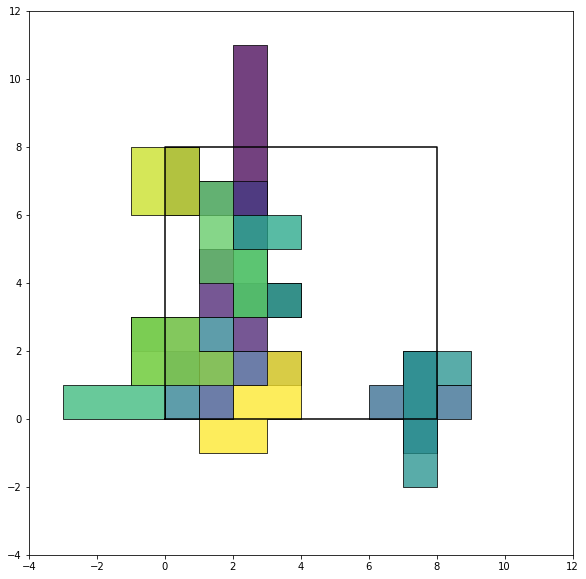

In [212]:
vecs = [np.random.randint(-1,board_size,2) for i in range(len(fblocks))]
rots = [np.random.randint(0,4) for i in range(len(fblocks))]
mirrs = [np.random.randint(0,1) for i in range(len(fblocks))]

settings = [(*vec, rot, mirr) for vec,rot,mirr in zip(vecs,rots,mirrs)]

plot_blocks(fblocks, settings)

In [213]:
# brute force it
brute_positions_x = np.array(list(range(board_size)))
brute_positions_y = brute_positions_x
brute_rotations = np.array(list(range(4)))
brute_mirrors = np.array(list(range(2)))

iterables = [brute_positions_x, brute_positions_y, brute_rotations, brute_mirrors]

all_combs = np.array(list(itertools.product(*iterables)))

In [291]:
def board_count(blocks):
    rblocks = np.array([block[...,:-1] for block in blocks])
    flats = np.concatenate(rblocks, axis=0)
    oob_area  = np.sum(np.abs(flats[np.where(flats < 0)]))
    oob_area += np.sum(flats[np.where(flats >= board_size)])
    return oob_area
    

def duplication_count(blocks):
    rblocks = np.array([block[...,:-1] for block in blocks])
    flats = np.concatenate(rblocks)
    flats = [tuple(x) for x in flats]
    flats_set = set()
    
    overlaps = 0
    for f in flats:
        if f in flats_set:
            overlaps += 1
        else:
            flats_set.add(f)
    return overlaps


def empty_blocks(blocks):
    rblocks = np.array([block[...,:-1] for block in blocks])
    flats = np.concatenate(rblocks)
    flats = set([tuple(x) for x in flats])
    full_set = set([(i,j) for i in range(board_size) for j in range(board_size)])
    for f in flats:
        if f in full_set:
            full_set.remove(f)
    return len(full_set)

def fitness_function(blocks):
    return board_count(blocks) + duplication_count(blocks) + empty_blocks(blocks)

In [292]:
class Individual(object): 
    ''' 
    Class representing individual in population 
    '''
    def __init__(self, chromosome=None): 
        if chromosome is None:
            chromosome = self.create_gnome()
        self.chromosome = np.array(chromosome)
        self.fitness = self.cal_fitness() 

    @classmethod
    def mutated_gene(self): 
        ''' 
        create random genes for mutation 
        '''
        return np.random.randint(0,NGENES)

    @classmethod
    def create_gnome(self): 
        ''' 
        create chromosome or string of genes 
        '''
        return np.random.randint(0, NGENES, NGNOMES)
    
    def mutate(self):
        self.chromosome[np.random.randint(NGNOMES)] = self.mutated_gene()
        return self

    def mate(self, par2): 
        ''' 
        Perform mating and produce new offspring 
        '''
        # chromosome for offspring 
        child_chromosome = []
        prob = np.random.rand(len(fblocks))
        for g1, g2, p in zip(self.chromosome, par2.chromosome, prob): 
            if p < 0.45:
                child_chromosome.append(g1)
            elif p < 0.9:
                child_chromosome.append(g2)
            else:
                child_chromosome.append(self.mutated_gene())
        child_chromosome = np.array(child_chromosome)
                
        return Individual(child_chromosome) 

    def cal_fitness(self): 
        ''' 
        Calculate fittness score, it is the number of 
        characters in string which differ from target 
        string. 
        '''
        blocks = move_blocks(self.chromosome)
        return fitness_function(blocks)

In [305]:
# Number of individuals in each generation 
NPOP = 50
NGENES = len(all_combs)
NGNOMES = len(fblocks)

#current generation 
generation = 1

found = False
failed = set()
population = [Individual() for i in range(int(NPOP))]
failed.update([tuple(ind.chromosome) for ind in population])

while not found: 
    population = sorted(population, key = lambda x:x.fitness) 

    # if the individual having lowest fitness score ie. 
    # 0 then we know that we have reached to the target 
    # and break the loop 
    if population[0].fitness <= 0: 
        found = True
        break

    # Otherwise generate new offsprings for new generation 
    new_generation = [] 

    # Perform Elitism, that mean 10% of fittest population 
    # goes to the next generation 
    elite = int(0.1*NPOP)
    spawn = int(0.4*NPOP)
    new_generation.extend(population[:elite]) 

    while len(new_generation) < elite+spawn:
        parent1, parent2 = np.random.choice(population[:spawn], 2, False)
        child = parent1.mate(parent2)
        if tuple(child.chromosome) not in failed:
            new_generation.append(child)
            failed.add(tuple(child.chromosome))

    while len(new_generation) < NPOP:
        new_ind = Individual()
        if tuple(new_ind.chromosome) not in failed:
            new_generation.append(new_ind)
            failed.add(tuple(new_ind.chromosome))
    population = new_generation 

    if generation % 10 == 0:
        print('\r', f'Generation: {generation}\tChromosome: {population[0].chromosome}\tFitness: {population[0].fitness}', end='\r') 
        
    if generation % 100 == 0:
        for idx, p in enumerate(population):
            if np.random.rand() > 0.5:
                p = p.mutate()
                population[idx] = p.mutate()
                if tuple(p.chromosome) not in failed:
                    failed.add(tuple(p.chromosome))

    if generation % 10000 == 0:
        new_generation = []
        while len(new_generation) < NPOP:
            new_ind = Individual()
            if tuple(new_ind.chromosome) not in failed:
                new_generation.append(new_ind)
                failed.add(tuple(new_ind.chromosome))
        population = new_generation 
        generation = 0        

    generation += 1

KeyboardInterrupt: 

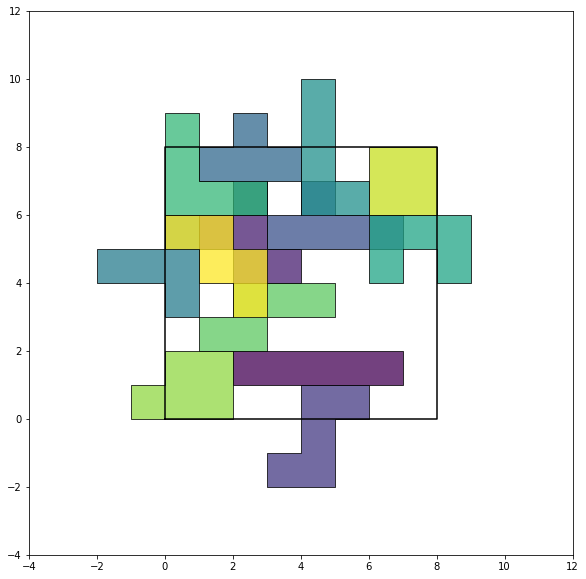

In [217]:
plot_blocks(move_blocks(population[0].chromosome))

In [218]:
res = Individual([6,91,334,133,232,499,378,176,454,211,419,48,72])
res = Individual([459,50,178,120,382,198,390,18,159,303,345,277,363])
res = Individual([133,23,511,91,346,314,460,403,61,212,238,363,144])
res = Individual([35,417,349,110,22,195,508,404,449,296,165,255,3])

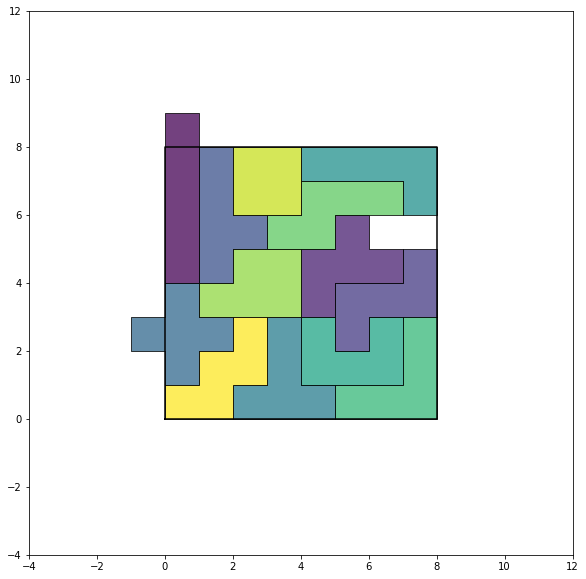

In [219]:
plot_blocks(move_blocks(res.chromosome))